<a href="https://colab.research.google.com/github/diego2017003/Mlops_student_freedata_analysis_pipeline/blob/main/Models/mlops_segregation_and_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse
import logging
import os
import seaborn as sns
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
#from clearml import StorageManager

In [2]:
!pip install clearml

In [3]:
!pip install clearml

In [4]:
!pip install clearml numpy clearml-agent 'pyjwt<1.8.0'

In [5]:
%%bash

export api=`cat <<EOF
api {
    # Stef Telford's workspace
    web_server: https://app.community.clrml.com
    api_server: https://api.community.clrml.com
    files_server: https://files.community.clrml.com
    credentials {
        "access_key" = "3ZJX3UQ9YS87PD4A1G"
        "secret_key" = "=OfK#N@Y&mFtC)VHWVqTJIb52QUZPfuJ&bSYD4!uUk(t7ENv"
    }
}
EOF
`
echo "$api" > /root/clearml.conf

In [6]:
# !clearml-agent daemon --queue default

In [7]:
# from clearml import StorageManager

# manager = StorageManager()
# dataset_path = manager.get_local_copy(
#     remote_url="https://files.clear.ml/a%20ML%20example/Prepreocessing.e08834ed846640c68d05d7b6d81b99e1/artifacts/processed_data/preprocessed_data.csv"
# )

In [8]:
data = pd.read_csv("preprocessed_data(1).csv",sep=',',encoding='utf-8')

In [9]:
# c = data.columns
# for i in c:
#   print(i)
#   print(data[i].value_counts())


In [10]:
data.area_conhecimento.value_counts()

Ciências da Saúde              2042
Ciências Exatas e da Terra     1745
Ciências Sociais Aplicadas     1128
Engenharias                    1050
Ciências Humanas                865
Linguística, Letras e Artes     724
Ciências Biológicas             535
Ciências Agrárias               191
Outra                            61
Name: area_conhecimento, dtype: int64

In [11]:
data['sexo'].replace({"M":"0","F":"1","false":"2"},inplace=True)
data['idade'] = 2020 - data['ano_nascimento'].astype(int)
data['local_ou_de_fora'] = (data['estado_origem']==('Rio Grande do Norte'))
data['raca'].fillna(value='Não Informado',inplace=True)
data['area_conhecimento'].fillna(value='Outra',inplace=True)
data['grau_academico'].fillna(value='OUTRO',inplace=True)
data['grau_academico'].replace({'BACHARELADO':'3', 'LICENCIATURA':'2', 'TECNOLÓGICO':'1',"OUTRO":"0"},inplace=True)
data['descricao'].replace({'APROVADO':'1',"FALHOU":"0","REPROVADO POR NOTA E FALTA":"0"},inplace=True)

In [12]:
data['raca'].unique()

array(['Negro', 'Branco', 'Pardo', 'Não Informado',
       'Amarelo (de origem oriental)', 'Indígena',
       'Remanescente de quilombo'], dtype=object)

In [13]:
X = data.drop(columns=['descricao'])
y = data['descricao']

In [14]:
!pip install imbalanced-learn

In [15]:
# from imblearn.under_sampling import RandomUnderSampler
# undersample = RandomUnderSampler(sampling_strategy=0.5)
# X_over, y_over = undersample.fit_resample(X, y)

In [16]:
# X_over['descricao'] = y_over
# data = X_over

In [17]:
# data.replace({"<":''},inplace=True)

In [18]:
#data.drop(columns=['ano_nascimento'],inplace=True)

In [19]:
data.columns

Index(['sexo', 'ano_nascimento', 'raca', 'estado_origem', 'cidade_origem',
       'renda', 'possui_auxilio_alimentacao', 'possui_auxilio_transporte',
       'possui_auxilio_residencia_moradia', 'grau_academico',
       'area_conhecimento', 'descricao', 'idade', 'local_ou_de_fora'],
      dtype='object')

In [20]:
#One label encoder 
from sklearn import preprocessing
columns = ['sexo', 'raca','possui_auxilio_alimentacao', 'possui_auxilio_transporte',
       'possui_auxilio_residencia_moradia', 'grau_academico',
       'area_conhecimento', 'descricao','local_ou_de_fora']
for i in columns:
  le = LabelEncoder()
  print(data[i].unique())
  le.fit(data[i].unique())
  data[i+"_le"] = le.transform(data[i])

['0' '1' '2']
['Negro' 'Branco' 'Pardo' 'Não Informado' 'Amarelo (de origem oriental)'
 'Indígena' 'Remanescente de quilombo']
[False  True]
[False  True]
[False  True]
['3' '2' '1' '0']
['Ciências Biológicas' 'Ciências da Saúde' 'Ciências Exatas e da Terra'
 'Engenharias' 'Ciências Sociais Aplicadas' 'Ciências Humanas'
 'Linguística, Letras e Artes' 'Ciências Agrárias' 'Outra']
['1' '0']
[False  True]


In [21]:
data = data.loc[:,['idade','renda','sexo_le', 'raca_le',
                   'possui_auxilio_alimentacao_le',
       'possui_auxilio_transporte_le', 'possui_auxilio_residencia_moradia_le',
       'grau_academico_le', 'area_conhecimento_le', 'local_ou_de_fora_le','descricao_le']]

In [22]:
# sns.pairplot(data=data,hue='descricao_le')

In [23]:
!pip install pycaret

In [24]:
from pycaret.classification import *

exp_name = setup(data = data,  target = 'descricao_le')

best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8120,0.0000,1.0000,0.8119,0.8962,0.0015,0.0086,0.038
lr,Logistic Regression,0.8118,0.6065,1.0000,0.8118,0.8961,0.0000,0.0000,0.706
ada,Ada Boost Classifier,0.8118,0.6135,0.9994,0.8121,0.8961,0.0034,0.0210,0.412
dummy,Dummy Classifier,0.8118,0.5000,1.0000,0.8118,0.8961,0.0000,0.0000,0.017
lda,Linear Discriminant Analysis,0.8114,0.6213,0.9994,0.8118,0.8959,0.0004,0.0038,0.041
gbc,Gradient Boosting Classifier,0.8092,0.5991,0.9958,0.8118,0.8944,0.0005,-0.0010,0.835
lightgbm,Light Gradient Boosting Machine,0.8015,0.5479,0.9848,0.8111,0.8896,-0.0065,-0.0125,0.139
knn,K Neighbors Classifier,0.7779,0.4940,0.9511,0.8089,0.8742,-0.0252,-0.0329,0.195
nb,Naive Bayes,0.7698,0.6043,0.9232,0.8172,0.8663,0.0381,0.0428,0.045
rf,Random Forest Classifier,0.7246,0.4760,0.8762,0.8027,0.8378,-0.0623,-0.0653,1.162


In [25]:
best_model

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=5496,
                solver='auto', tol=0.001)

In [26]:
x_train,x_test,y_train,y_test = train_test_split(data.drop(columns=['descricao_le']),
                                                      data['descricao_le'],
                                                      test_size=0.2,
                                                      random_state=2,
                                                      shuffle=True,
                                                      stratify = data['descricao_le'])

In [27]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=194, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False).fit(x_train, y_train)

In [28]:
y_predict = lr.predict(x_test)

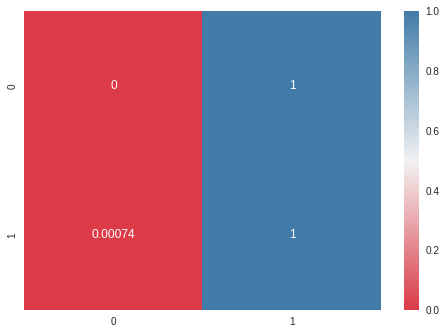

In [32]:
cm = confusion_matrix(y_true=y_test,y_pred=y_predict,normalize='true')

cmap = sns.diverging_palette(10, 240, as_cmap=True)

sns.heatmap(cm,cmap=cmap, annot=True)

In [34]:
print(classification_report(y_true=y_test,y_pred=y_predict))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       318
           1       0.81      1.00      0.89      1351

    accuracy                           0.81      1669
   macro avg       0.40      0.50      0.45      1669
weighted avg       0.66      0.81      0.72      1669



In [30]:
import sklearn
sklearn.metrics.SCORERS

{'accuracy': make_scorer(accuracy_score),
 'adjusted_mutual_info_score': make_scorer(adjusted_mutual_info_score),
 'adjusted_rand_score': make_scorer(adjusted_rand_score),
 'average_precision': make_scorer(average_precision_score, needs_threshold=True),
 'balanced_accuracy': make_scorer(balanced_accuracy_score),
 'completeness_score': make_scorer(completeness_score),
 'explained_variance': make_scorer(explained_variance_score),
 'f1': make_scorer(f1_score, average=binary),
 'f1_macro': make_scorer(f1_score, pos_label=None, average=macro),
 'f1_micro': make_scorer(f1_score, pos_label=None, average=micro),
 'f1_samples': make_scorer(f1_score, pos_label=None, average=samples),
 'f1_weighted': make_scorer(f1_score, pos_label=None, average=weighted),
 'fowlkes_mallows_score': make_scorer(fowlkes_mallows_score),
 'homogeneity_score': make_scorer(homogeneity_score),
 'jaccard': make_scorer(jaccard_score, average=binary),
 'jaccard_macro': make_scorer(jaccard_score, pos_label=None, average=mac

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
X = data.drop(columns=['descricao_le'])
y = data['descricao_le']
param_grid = [
        {
            'activation' : ['identity', 'logistic', 'tanh', 'relu'],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'solver' : ['lbfgs', 'sgd', 'adam'],
            'hidden_layer_sizes': [
             (1,1,),(1,2,),(1,3,),(1,4,),(1,5,),(2,1,),(2,2,),(2,3,),(2,4,),(2,5,),(3,1,),(3,2,),(3,3,),(3,4,),(3,5,)
             ,(4,1,),(4,2,),(4,3,),(4,4,),(4,5,),(5,1,),(5,2,),(5,3,),(5,4,),(5,5,)
             ]
        }
       ]
clf = GridSearchCV(MLPClassifier(), param_grid, cv=3,scoring='precision')

clf.fit(X,y)


print("Best parameters set found on development set:")
print(clf.best_params_)

Best parameters set found on development set:
{'activation': 'identity', 'hidden_layer_sizes': (5, 3), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}


In [ ]:
#precision_mean_macro_{'activation': 'identity', 'hidden_layer_sizes': (1, 1), 'learning_rate': 'adaptive', 'solver': 'adam'}
#precision_{'activation': 'identity', 'hidden_layer_sizes': (5, 3), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       318
           1       0.81      1.00      0.89      1351

    accuracy                           0.81      1669
   macro avg       0.40      0.50      0.45      1669
weighted avg       0.66      0.81      0.72      1669



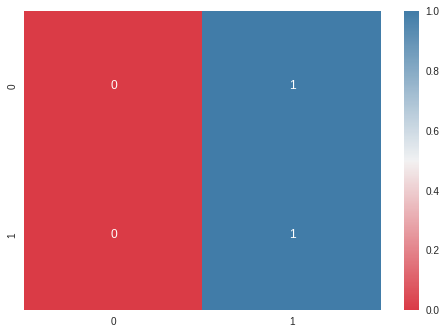

In [45]:
from sklearn.neural_network import MLPClassifier

mlp1 = MLPClassifier(activation= 'identity', hidden_layer_sizes= (1, 1), learning_rate= 'adaptive', solver= 'adam')
mlp2= MLPClassifier(activation= 'identity', hidden_layer_sizes= (5, 3), learning_rate= 'adaptive', solver= 'lbfgs')
mlp1.fit(x_train,y_train)
mlp2.fit(x_train,y_train)

y_pred1 = mlp1.predict(x_test)
y_pred2 = mlp2.predict(x_test)

cm = confusion_matrix(y_true=y_test,y_pred=y_pred1,normalize='true')

cmap = sns.diverging_palette(10, 240, as_cmap=True)
print(classification_report(y_true=y_test,y_pred=y_pred1))
sns.heatmap(cm,cmap=cmap, annot=True)

              precision    recall  f1-score   support

           0       0.20      0.36      0.26       318
           1       0.82      0.67      0.73      1351

    accuracy                           0.61      1669
   macro avg       0.51      0.51      0.50      1669
weighted avg       0.70      0.61      0.64      1669



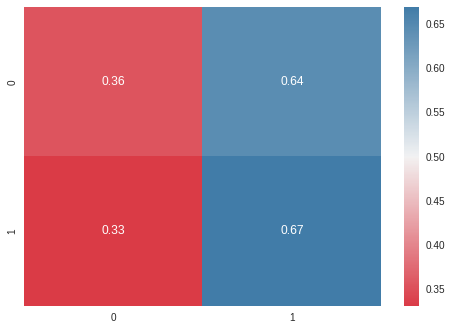

In [46]:
cm = confusion_matrix(y_true=y_test,y_pred=y_pred2,normalize='true')

cmap = sns.diverging_palette(10, 240, as_cmap=True)
print(classification_report(y_true=y_test,y_pred=y_pred2))
sns.heatmap(cm,cmap=cmap, annot=True)